In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import datetime
import numpy as np
import torch
import torch.nn.functional as F

torch.autograd.set_detect_anomaly(True)
# torch.set_default_dtype(torch.float32)

import mediapy as mpy
from tqdm.auto import tqdm
from IPython.display import clear_output, display
import matplotlib.pyplot as plt
import wandb

from nca_model import SimpleNCA
from utils import nca_out_to_vids, tonp, save_model, load_latest_model, nca_cmap, pad_to, nca_clamp
from data import (
    MNISTPatternGenerator,
    MNISTPatternPool,
    generate_radial_circles_pattern,
    generate_canonical_mnist_digits,
)

In [3]:
device = "cuda"
num_classes = 10
channs = 16
bs = 16
S = 80
lr = 0.0008
pool_size = 64
pool_replacement = 0.8

In [10]:
# with open(".checkpoints/nca-80-radial/nca-45250-[2025-05-06-18-27-08].pkl", "rb") as fp:
#     loaded_nca = torch.load(fp).to(device)

with open(".checkpoints/nca-80-radial/nca-3000-[2025-05-07-15-51-03].pkl", "rb") as fp:
    loaded_nca = torch.load(fp).to(device)

In [11]:
rollouts = []
with torch.inference_mode():
    item = test_gen.ds[0]
    inp = item["inp"].unsqueeze(0).to(device)
    out_pred = loaded_nca(inp, steps=80)
    rollout = tonp(out_pred[:, 0, 0])

,,,

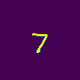
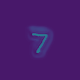
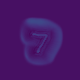
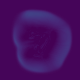

In [12]:
mpy.show_images([rollout[i] for i in [0, 10, 20, 30]], cmap="viridis", width=150, vmin=0, vmax=0.8)

## Test CLF

""

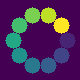

In [16]:
screen = np.zeros((80, 80))
for i in range(10):
    screen[pattern[i] == 1] = i + 1
    
mpy.show_image(screen, cmap="viridis", width=150)

In [13]:
# with open(".checkpoints/nca-80-radial/nca-45250-[2025-05-06-18-27-08].pkl", "rb") as fp:
#     loaded_nca = torch.load(fp).to(device)
    
# with open(".checkpoints/nca-80-radial/nca-49750-[2025-05-07-22-16-01].pkl", "rb") as fp:
#     loaded_nca = torch.load(fp).to(device)

# with open(".checkpoints/nca-80-radial-2/nca-99750-[2025-05-08-17-06-45].pkl", "rb") as fp: # paper checkpoint
#     loaded_nca = torch.load(fp).to(device)

with open(".checkpoints/nca-80-radial-2-continue/nca-199750-[2025-05-11-04-12-02].pkl", "rb") as fp: # after paper checkpoint
    loaded_nca = torch.load(fp).to(device)

In [256]:
pattern = generate_radial_circles_pattern(S, num_classes)
test_gen = MNISTPatternGenerator(
    is_train=False,
    channs=channs,
    pattern=pattern,
    bs=1,
    loop_forever=False,
    shuffle=False,
)

test_recs = []
for batch in tqdm(test_gen):
    with torch.inference_mode():
        inp, out_gt = batch["inp"], batch["out"]
        out_gt = out_gt.to(device)[:, 0]
        out_pred = loaded_nca(inp.to(device), steps=30)
        last_frame = out_pred[-1][:, 0]
        loss = F.mse_loss(last_frame, out_gt)
        probs = np.array([
            (pattern[c] * last_frame[0].cpu()).mean().item()
            for c in range(num_classes)
        ])
        pred = probs.argmax()

        test_recs.append({
            "label": batch["label"].item(),
            "loss": loss.item(),
            "probs": probs,
            "prob": probs[pred],
            "pred": pred,
        })

  0%|          | 0/10000 [00:00<?, ?it/s]

In [17]:
import pandas as pd
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

In [258]:
test_df = pd.DataFrame(test_recs).reset_index()
test_df.head()

,index,label,loss,probs,prob,pred
0,0,7,0.005987,"[0.00043928486142249314, 0.001360098809200281,...",0.023624,7
1,1,2,0.013883,"[0.00035943985436460936, 0.002890192361155641,...",0.023320,2
2,2,1,0.009951,"[0.0006871033620700473, 0.019194493752147535, ...",0.019194,1
3,3,0,0.010985,"[0.021087269691051916, 0.00035460120416246353,...",0.021087,0
4,4,4,0.009021,"[0.001089397764444584, 0.00022339843133522663,...",0.020904,4


In [11]:
(test_df["pred"] == test_df["label"]).mean() # paper result

0.9136

In [259]:
(test_df["pred"] == test_df["label"]).mean() # after paper result

0.9338

In [12]:
print(classification_report(test_df["label"], test_df["pred"])) # paper result

              precision    recall  f1-score   support

           0       0.88      0.97      0.92       980
           1       0.94      0.98      0.96      1135
           2       0.93      0.94      0.94      1032
           3       0.89      0.86      0.88      1010
           4       0.81      0.94      0.87       982
           5       0.91      0.88      0.90       892
           6       0.96      0.97      0.96       958
           7       0.92      0.92      0.92      1028
           8       0.97      0.89      0.93       974
           9       0.94      0.78      0.85      1009

    accuracy                           0.91     10000
   macro avg       0.92      0.91      0.91     10000
weighted avg       0.92      0.91      0.91     10000



In [260]:
print(classification_report(test_df["label"], test_df["pred"])) # paper result

              precision    recall  f1-score   support

           0       0.93      0.98      0.95       980
           1       0.98      0.97      0.97      1135
           2       0.93      0.95      0.94      1032
           3       0.82      0.95      0.88      1010
           4       0.90      0.96      0.93       982
           5       0.96      0.76      0.85       892
           6       0.95      0.97      0.96       958
           7       0.96      0.94      0.95      1028
           8       0.98      0.93      0.95       974
           9       0.96      0.92      0.94      1009

    accuracy                           0.93     10000
   macro avg       0.94      0.93      0.93     10000
weighted avg       0.94      0.93      0.93     10000



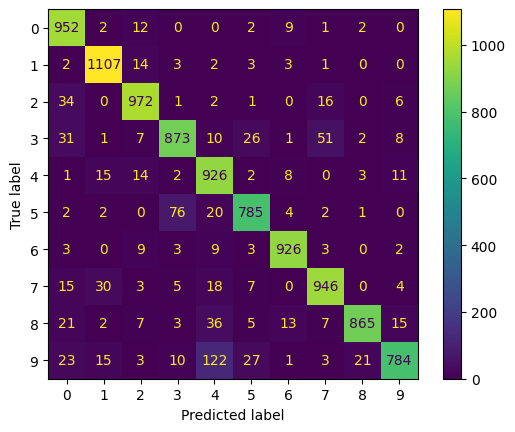

In [13]:
ConfusionMatrixDisplay.from_predictions(test_df["label"], test_df["pred"])

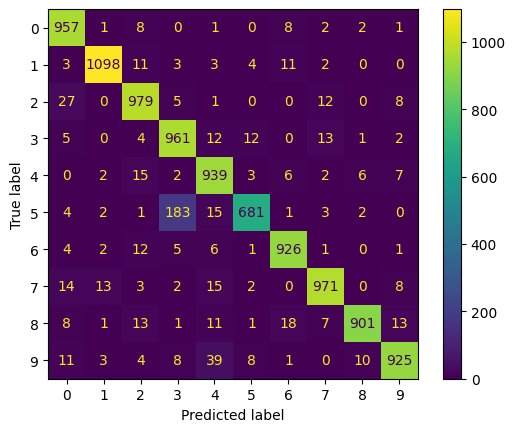

In [261]:
ConfusionMatrixDisplay.from_predictions(test_df["label"], test_df["pred"])

## Test Good Example

In [225]:
grouped = []
for i in range(num_classes):
    item = test_df.groupby("label").get_group(i).sort_values("loss").iloc[0]
    grouped.append(item.to_dict())

group_ids = [int(g["index"]) for g in grouped]

In [226]:
rollouts = []
with torch.inference_mode():
    for idx in tqdm(group_ids):
        item = test_gen.ds[idx]
        inp = item["inp"].unsqueeze(0).to(device)
        out_pred = loaded_nca(inp, steps=50)
        rollout = tonp(out_pred[:, 0, :])
        rollouts.append(rollout)

  0%|          | 0/10 [00:00<?, ?it/s]

,,,,,,,,,,

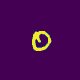
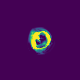
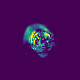
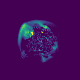
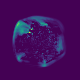
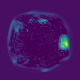
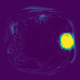
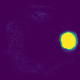
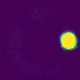
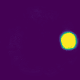
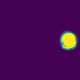

,,,,,,,,,,

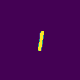
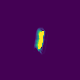
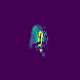
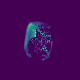
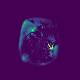
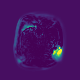
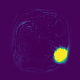
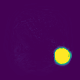
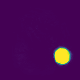
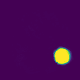
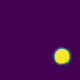

,,,,,,,,,,

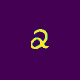
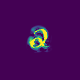
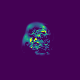
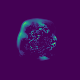
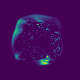
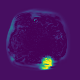
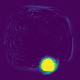
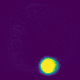
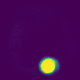
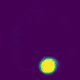
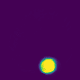

,,,,,,,,,,

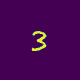
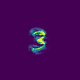
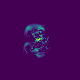
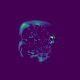
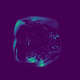
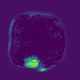
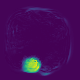
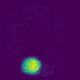
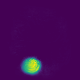
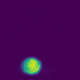
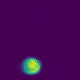

,,,,,,,,,,

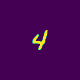
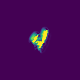
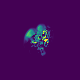
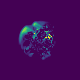
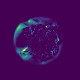
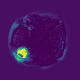
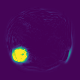
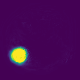
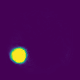
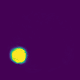
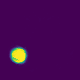

,,,,,,,,,,

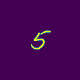
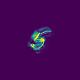
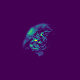
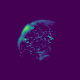
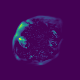
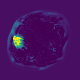
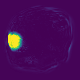
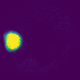
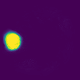
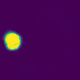
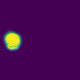

,,,,,,,,,,

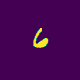
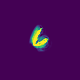
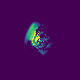
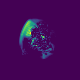
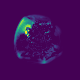
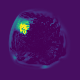
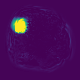
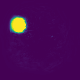
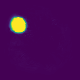
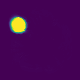
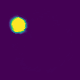

,,,,,,,,,,

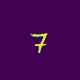
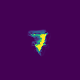
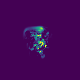
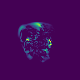
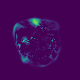
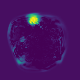
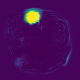
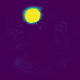
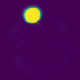
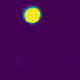
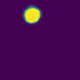

,,,,,,,,,,

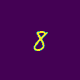
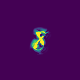
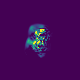
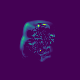
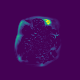
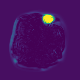
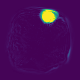
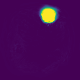
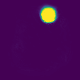
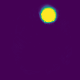
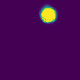

,,,,,,,,,,

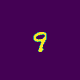
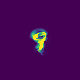
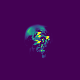
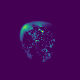
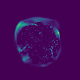
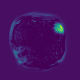
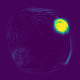
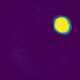
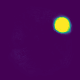
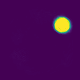
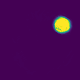

In [184]:
for i in range(num_classes):
    mpy.show_images(rollouts[i][::5], cmap="viridis", width=100, vmin=0, vmax=0.9)

# mpy.show_images(
#     [np.array(test_gen.pattern[i]) for i, r in enumerate(rollouts)],
#     cmap="viridis", width=100, vmin=0, vmax=1,
# )

,,,,,

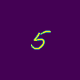
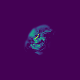
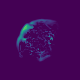
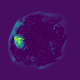
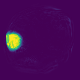
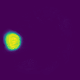

In [185]:
mpy.show_images(rollouts[5][[0, 8, 16, 24, 32, 40]], cmap="viridis", width=150, vmin=0, vmax=1)

In [59]:
def softmax(z):
    e = np.exp(z)
    return e / np.sum(e)

In [79]:
rollout = rollouts[5]
probs_in_time = []
for r in rollout:
    probs = (np.array([
        ((pattern[c] * r).sum() / pattern[c].sum()).item()
        for c in range(num_classes)
    ]))
    probs_in_time.append(probs.tolist())
    
probs_in_time = np.array(probs_in_time)

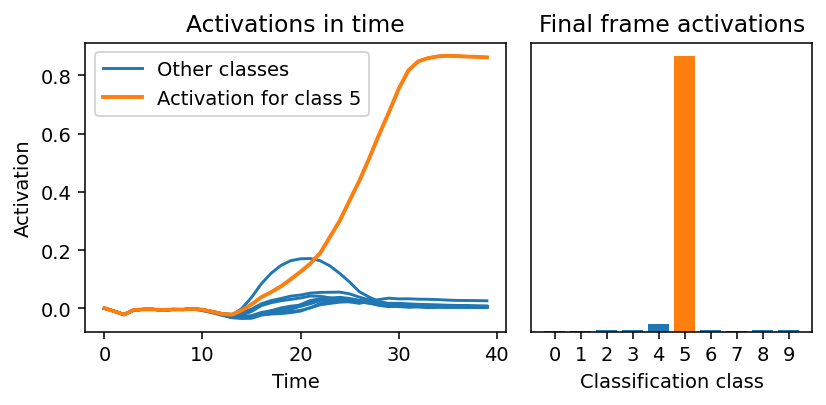

In [181]:
fig, axs = plt.subplots(1, 2, dpi=140, figsize=(6, 3), gridspec_kw={'width_ratios': [1.5, 1]})

for c in range(num_classes - 1):
    axs[0].plot(probs_in_time[:40, c], c="tab:blue")

axs[0].plot(probs_in_time[:40, num_classes - 1], c="tab:blue", label="Other classes")


axs[0].plot(probs_in_time[:40, 5], c="tab:orange", linewidth=2, label="Activation for class 5")
axs[0].set_xlabel("Time")
axs[0].set_ylabel("Activation")
axs[0].set_title("Activations in time")
# axs[0].set_aspect(15)
axs[0].legend()

# plt.xticks([])
# plt.yticks([])

c = ["tab:blue"] * 10
c[5] = "tab:orange"
axs[1].bar(range(num_classes), probs_in_time[40, :], color=c)
axs[1].set_xticks(range(10))
axs[1].set_yticks([])
# axs[1].set_aspect(15)
axs[1].set_xlabel("Classification class")
axs[1].set_title("Final frame activations")

plt.tight_layout()
plt.show()

In [252]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [253]:
vids = [
    np.concatenate(mpy.to_rgb(
        np.concatenate([r[:1].repeat(20, axis=0), r, r[-1:].repeat(20, axis=0)]),
        cmap="viridis",
        vmin=0, vmax=1,
    ).swapaxes(0, 1)[[0]], axis=1)
    for r in rollouts
]
mpy.show_videos(
    vids,
    width=120,
    codec="gif",
    fps=25
)

## Test Bad Example

  0%|          | 0/10 [00:00<?, ?it/s]

,,,,,,,,

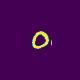
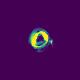
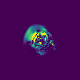
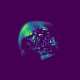
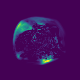
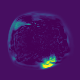
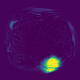
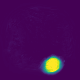
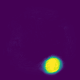

,,,,,,,,

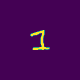
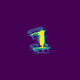
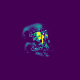
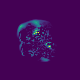
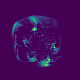
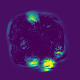
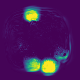
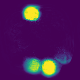
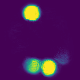

,,,,,,,,

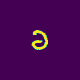
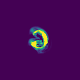
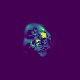
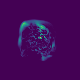
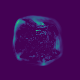
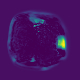
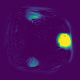
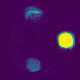
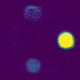

,,,,,,,,

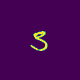
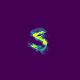
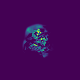
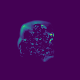
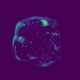
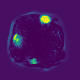
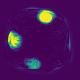
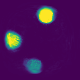
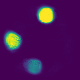

,,,,,,,,

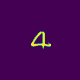
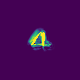
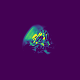
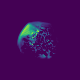
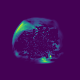
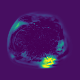
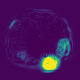
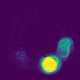
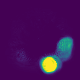

,,,,,,,,

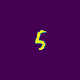
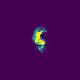
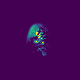
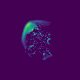
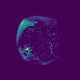
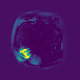
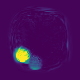
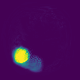
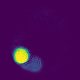

,,,,,,,,

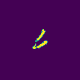
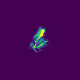
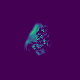
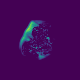
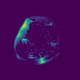
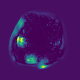
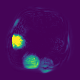
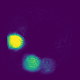
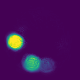

,,,,,,,,

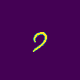
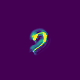
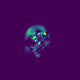
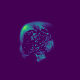
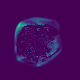
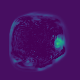
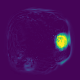
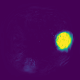
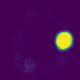

,,,,,,,,

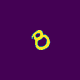
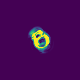
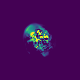
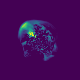
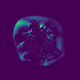
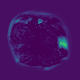
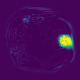
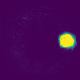
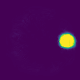

,,,,,,,,

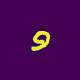
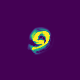
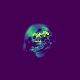
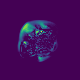
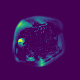
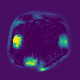
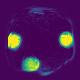
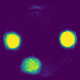
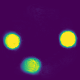

In [212]:
grouped = []
for i in range(num_classes):
    item = test_df.groupby("label").get_group(i).sort_values("loss").iloc[-1]
    grouped.append(item.to_dict())

group_ids = [int(g["index"]) for g in grouped]

rollouts = []
with torch.inference_mode():
    for idx in tqdm(group_ids):
        item = test_gen.ds[idx]
        inp = item["inp"].unsqueeze(0).to(device)
        out_pred = loaded_nca(inp, steps=40)
        rollout = tonp(out_pred[:, 0, 0])
        rollouts.append(rollout)
        
for i in range(num_classes):
    mpy.show_images(rollouts[i][::5], cmap="viridis", width=100, vmin=0, vmax=0.9)

# mpy.show_images(
#     [np.array(test_gen.pattern[i]) for i, r in enumerate(rollouts)],
#     cmap="viridis", width=100, vmin=0, vmax=1,
# )

In [254]:
mpy.show_videos(
    [
        mpy.to_rgb(
            np.concatenate([r[:1].repeat(20, axis=0), r, r[-1:].repeat(20, axis=0)]),
            cmap="viridis",
            vmin=0, vmax=1,
        )
        for r in rollouts
    ],
    width=200,
    codec="gif",
    fps=20
)

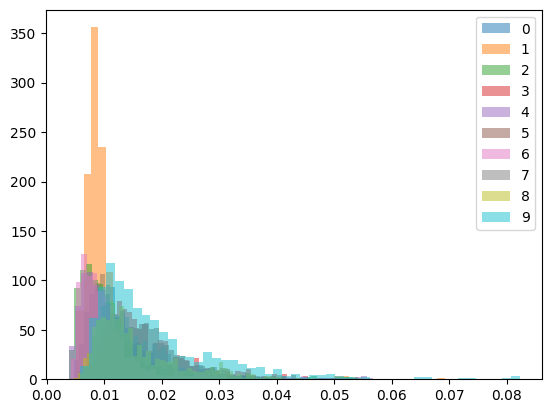

In [25]:
for c in range(num_classes):
    losses = test_df[test_df["label"] == c]["loss"]
    plt.hist(losses, bins=50, alpha=0.5, label=c)
plt.legend()

## First-last frame

In [94]:
frames = []
for i in tqdm(range(num_classes)):
    vs = test_df.groupby("label").get_group(i).sort_values("loss")
    item = vs.iloc[[0, 500, -5]]
    it = {k: list(v.values()) for k, v in item.to_dict().items()}

    last_frames = []
    with torch.inference_mode():
        for idx in it["index"]:
            item = test_gen.ds[idx]
            inp = item["inp"].unsqueeze(0).to(device)
            out_pred = loaded_nca(inp, steps=100)
            last_frame = tonp(out_pred[-1, 0, 0])
            first_frame = tonp(out_pred[0, 0, 0])

            last_frames.append(first_frame)
            last_frames.append(last_frame)

    frames.append(last_frames)

  0%|          | 0/10 [00:00<?, ?it/s]

,,,,,,,,,

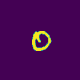
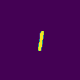
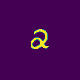
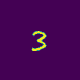
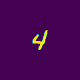
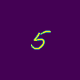
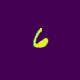
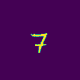
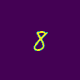
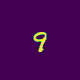

,,,,,,,,,

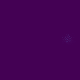
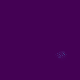
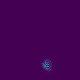
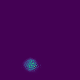
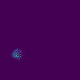
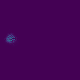
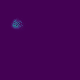
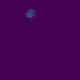
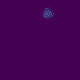
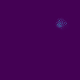

,,,,,,,,,

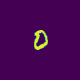
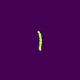
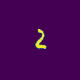
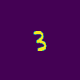
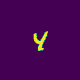
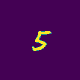
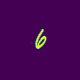
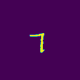
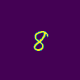
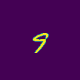

,,,,,,,,,

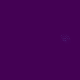
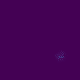
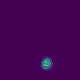
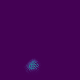
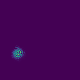
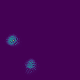
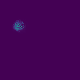
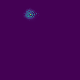
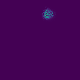
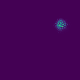

,,,,,,,,,

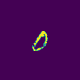
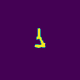
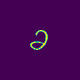
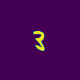
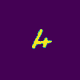
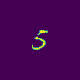
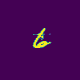
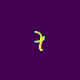
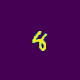
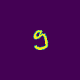

,,,,,,,,,

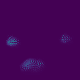
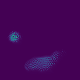
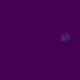
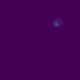
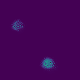
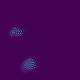
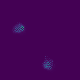
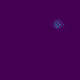
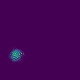
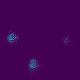

In [95]:
for i in range(len(frames[0])):
    mpy.show_images([fs[i] for fs in frames], cmap="viridis", width=100, vmin=0, vmax=1)

## Train CLF

In [15]:
pattern = generate_radial_circles_pattern(S, num_classes)
train_gen = MNISTPatternGenerator(
    is_train=True,
    channs=channs,
    pattern=pattern,
    bs=1,
    loop_forever=False,
    shuffle=False,
)

train_recs = []
for batch in tqdm(train_gen):
    with torch.inference_mode():
        inp, out_gt = batch["inp"], batch["out"]
        out_gt = out_gt.to(device)[:, 0]
        out_pred = loaded_nca(inp.to(device), steps=40)
        last_frame = out_pred[-1][:, 0]
        loss = F.mse_loss(last_frame, out_gt)
        probs = np.array([
            (pattern[c] * last_frame[0].cpu()).mean().item()
            for c in range(num_classes)
        ])
        pred = probs.argmax()

        train_recs.append({
            "label": batch["label"].item(),
            "loss": loss.item(),
            "probs": probs,
            "prob": probs[pred],
            "pred": pred,
        })

  0%|          | 0/60000 [00:00<?, ?it/s]

In [18]:
train_df = pd.DataFrame(train_recs).reset_index()
train_df.head()

,index,label,loss,probs,prob,pred
0,0,5,0.052305,"[-7.428370212437585e-05, -5.834063278598478e-0...",0.023208,3
1,1,0,0.003681,"[0.0274126618122682, 3.7744016117358116e-05, -...",0.027413,0
2,2,4,0.004203,"[-3.773449250729755e-05, 2.801389928208664e-07...",0.024049,4
3,3,1,0.002259,"[3.317839746159734e-05, 0.027556560733355582, ...",0.027557,1
4,4,9,0.002542,"[4.0886571805458513e-05, -1.0477546238689683e-...",0.026086,9


In [30]:
(train_df["pred"] == train_df["label"]).mean() # paper result

0.9247166666666666

In [19]:
(train_df["pred"] == train_df["label"]).mean() # after paper result

0.9449333333333333

In [31]:
print(classification_report(train_df["label"], train_df["pred"])) # paper result

              precision    recall  f1-score   support

           0       0.89      0.98      0.93      5923
           1       0.97      0.96      0.97      6742
           2       0.92      0.93      0.92      5958
           3       0.93      0.84      0.88      6131
           4       0.83      0.95      0.88      5842
           5       0.92      0.90      0.91      5421
           6       0.97      0.97      0.97      5918
           7       0.92      0.95      0.93      6265
           8       0.97      0.92      0.94      5851
           9       0.95      0.83      0.89      5949

    accuracy                           0.92     60000
   macro avg       0.93      0.92      0.92     60000
weighted avg       0.93      0.92      0.92     60000



In [20]:
print(classification_report(train_df["label"], train_df["pred"])) # after paper result

              precision    recall  f1-score   support

           0       0.96      0.97      0.96      5923
           1       0.99      0.97      0.98      6742
           2       0.93      0.95      0.94      5958
           3       0.88      0.94      0.91      6131
           4       0.90      0.96      0.93      5842
           5       0.94      0.86      0.90      5421
           6       0.97      0.97      0.97      5918
           7       0.97      0.95      0.96      6265
           8       0.97      0.94      0.96      5851
           9       0.94      0.92      0.93      5949

    accuracy                           0.94     60000
   macro avg       0.95      0.94      0.94     60000
weighted avg       0.95      0.94      0.94     60000



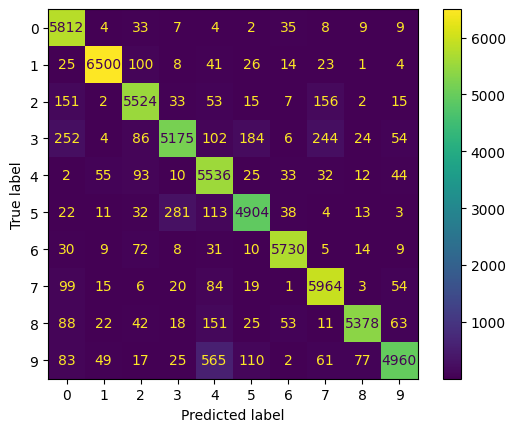

In [32]:
ConfusionMatrixDisplay.from_predictions(train_df["label"], train_df["pred"])

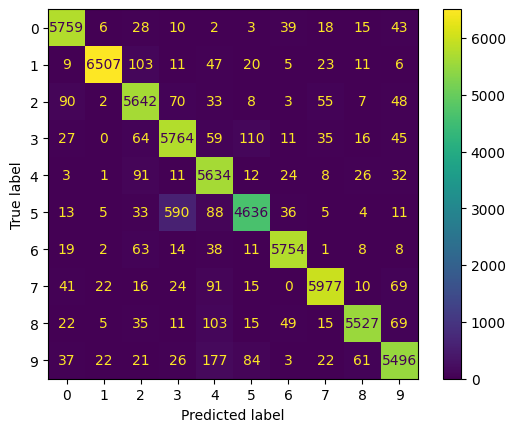

In [21]:
ConfusionMatrixDisplay.from_predictions(train_df["label"], train_df["pred"])